# Exploration et visualisation des données satellite Northwest 2019

Ce notebook permet de visualiser l'ensemble des données satellite du dossier Northwest_2019.

## Sources des données

Les fichiers NetCDF contiennent des données fusionnées de plusieurs capteurs :

- **SAR Sentinel-1** : Radar à synthèse d'ouverture (bandes C) en polarisation HH et HV
- **AMSR-2** : Radiomètre micro-ondes (températures de brillance de 6.9 à 89 GHz)
- **Cartes de glace** : Annotations manuelles des types de glace (ice charts)

## Zone géographique

Région Nord-Ouest du Groenland, période : janvier à mai 2019.

## Imports et configuration

Chargement des bibliothèques nécessaires pour la manipulation et la visualisation des données.

In [1]:
# Imports
# xarray : bibliothèque pour manipuler des données multidimensionnelles étiquetées (comme les fichiers NetCDF)
import xarray as xr

# matplotlib : bibliothèque de visualisation pour créer des graphiques
import matplotlib.pyplot as plt

# numpy : bibliothèque pour le calcul numérique sur des tableaux
import numpy as np

# pathlib : gestion des chemins de fichiers de manière multiplateforme (Windows/Linux/Mac)
from pathlib import Path

# Masquer les warnings pour plus de lisibilité dans le notebook
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Configuration de l'affichage
# Taille par défaut des figures (largeur, hauteur) en pouces
plt.rcParams['figure.figsize'] = (12, 8)

# Résolution des figures en points par pouce (DPI)
plt.rcParams['figure.dpi'] = 100

## Chargement des fichiers NetCDF

Les fichiers NetCDF (.nc) sont un format standard pour les données scientifiques géospatiales.
Chaque fichier correspond à une acquisition satellite à une date donnée.

In [3]:
# Liste des fichiers disponibles
# Chemin vers le dossier contenant les données
data_dir = Path("Northwest_2019")

# Récupération de tous les fichiers .nc triés par nom (donc par date)
# glob("*.nc") retourne tous les fichiers avec l'extension .nc
nc_files = sorted(data_dir.glob("*.nc"))

# Affichage du nombre de fichiers et leurs noms
print(f"Nombre de fichiers trouvés : {len(nc_files)}\n")
for f in nc_files:
    # Le nom de fichier contient : date_heure_satellite_capteur_zone.nc
    print(f"  - {f.name}")

Nombre de fichiers trouvés : 6

  - 20190105T205535_S1B_AMSR2_Icechart-Greenland-NorthWest.nc
  - 20190304T103943_S1A_AMSR2_Icechart-Greenland-NorthWest.nc
  - 20190304T104047_S1A_AMSR2_Icechart-Greenland-NorthWest.nc
  - 20190409T103943_S1A_AMSR2_Icechart-Greenland-NorthWest.nc
  - 20190409T104048_S1A_AMSR2_Icechart-Greenland-NorthWest.nc
  - 20190522T210439_S1B_AMSR2_Icechart-Greenland-NorthWest.nc


## 1. Structure d'un fichier NetCDF

Un fichier NetCDF contient :
- **Dimensions** : définissent la taille des tableaux (ex: sar_lines, sar_samples)
- **Coordonnées** : valeurs associées aux dimensions (ex: latitude, longitude)
- **Variables** : les données elles-mêmes (ex: images SAR, températures de brillance)
- **Attributs** : métadonnées (ex: description, version)

In [4]:
# Chargement du premier fichier
# open_dataset() charge le fichier NetCDF en mémoire
# engine="h5netcdf" : utilise le moteur h5netcdf (meilleure compatibilité avec les chemins Unicode)
ds = xr.open_dataset(nc_files[0], engine="h5netcdf")

# Affichage de la structure complète du dataset
# On voit les dimensions, coordonnées, variables et attributs
print(ds)

<xarray.Dataset> Size: 3GB
Dimensions:                  (sar_samples: 10430, sar_lines: 9993,
                              sar_grid_points: 441, line: 200, sample: 210,
                              delay: 4, polygon_codes: 23)
Coordinates:
  * line                     (line) int32 800B 25 75 125 175 ... 9875 9925 9975
  * sample                   (sample) int32 840B 25 75 125 ... 10375 10425 10475
  * polygon_codes            (polygon_codes) <U51 5kB 'id;CT;CA;SA;FA;CB;SB;F...
    lon                      (line, sample) float64 336kB ...
    lat                      (line, sample) float64 336kB ...
    delays                   (line, sample) float64 336kB ...
Dimensions without coordinates: sar_samples, sar_lines, sar_grid_points, delay
Data variables: (12/32)
    sar_incidenceangles      (sar_samples) float32 42kB ...
    sar_primary              (sar_lines, sar_samples) float32 417MB ...
    sar_secondary            (sar_lines, sar_samples) float32 417MB ...
    polygon_icechart   

In [5]:
# Liste détaillée des variables
# Pour chaque variable, on affiche ses dimensions et sa forme (shape)
print("Variables disponibles :")
print("" * 60)

for var in ds.data_vars:
    shape = ds[var].shape  # Taille du tableau (ex: (9993, 10430) pour une image)
    dims = ds[var].dims    # Noms des dimensions (ex: ('sar_lines', 'sar_samples'))
    print(f"{var:30s} | dims: {dims} | shape: {shape}")

Variables disponibles :

sar_incidenceangles            | dims: ('sar_samples',) | shape: (10430,)
sar_primary                    | dims: ('sar_lines', 'sar_samples') | shape: (9993, 10430)
sar_secondary                  | dims: ('sar_lines', 'sar_samples') | shape: (9993, 10430)
polygon_icechart               | dims: ('sar_lines', 'sar_samples') | shape: (9993, 10430)
sar_grid_line                  | dims: ('sar_grid_points',) | shape: (441,)
sar_grid_sample                | dims: ('sar_grid_points',) | shape: (441,)
sar_grid_latitude              | dims: ('sar_grid_points',) | shape: (441,)
sar_grid_longitude             | dims: ('sar_grid_points',) | shape: (441,)
sar_grid_incidenceangle        | dims: ('sar_grid_points',) | shape: (441,)
sar_grid_height                | dims: ('sar_grid_points',) | shape: (441,)
distance_map                   | dims: ('sar_lines', 'sar_samples') | shape: (9993, 10430)
nersc_sar_primary              | dims: ('sar_lines', 'sar_samples') | shape: (999

### Explication des variables principales

| Variable | Description | Dimensions |
|----------|-------------|------------|
| `nersc_sar_primary` | Image SAR polarisation HH calibrée (dB) | ~10000 x 10000 pixels |
| `nersc_sar_secondary` | Image SAR polarisation HV calibrée (dB) | ~10000 x 10000 pixels |
| `polygon_icechart` | Carte des types de glace (codes) | ~10000 x 10000 pixels |
| `btemp_XX.Xh/v` | Température de brillance AMSR-2 à XX.X GHz, polarisation H ou V | 200 x 210 pixels |
| `lat`, `lon` | Coordonnées géographiques | 200 x 210 pixels |
| `sar_incidenceangles` | Angle d'incidence du radar pour chaque colonne | 10000+ valeurs |

## 2. Données SAR Sentinel-1

Le radar à synthèse d'ouverture (SAR) mesure la rétrodiffusion des micro-ondes.

- **Polarisation HH** : émission et réception horizontales → sensible à la rugosité de surface
- **Polarisation HV** : émission horizontale, réception verticale → sensible au volume (neige, glace)

Les valeurs sont en décibels (dB), typiquement entre -30 dB et +15 dB.

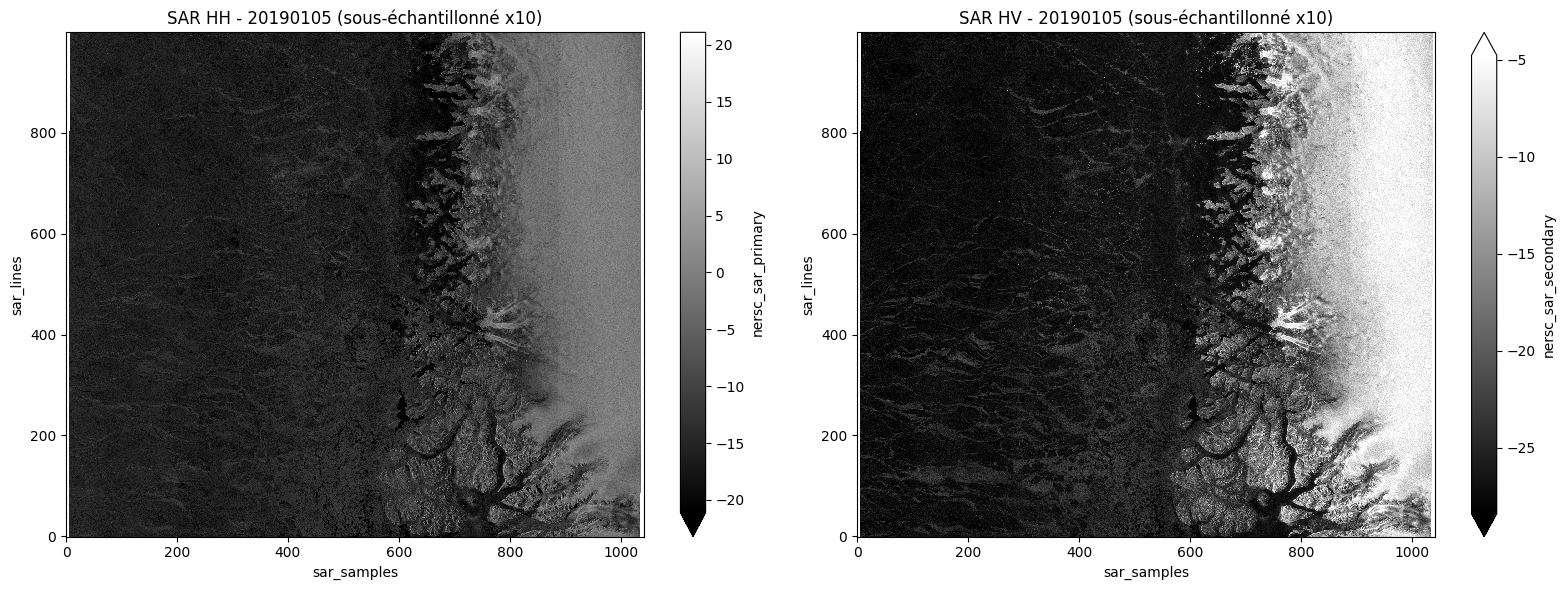

In [6]:
# Visualisation SAR HH et HV
# Les images SAR font ~10000x10000 pixels, ce qui représente ~400 Mo par image
# Pour éviter les erreurs de mémoire, on sous-échantillonne par 10 (1 pixel sur 10)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# SAR HH (polarisation primaire)
# Extraction de la variable depuis le dataset
hh = ds["nersc_sar_primary"]

# Sous-échantillonnage : [::10, ::10] prend 1 pixel sur 10 dans chaque dimension
# Cela réduit la taille de 10000x10000 à 1000x1000 pixels
hh_subsampled = hh[::10, ::10]

# plot() avec robust=True ajuste automatiquement les couleurs (ignore les valeurs extrêmes)
# cmap="gray" : palette de gris (standard pour les images SAR)
hh_subsampled.plot(ax=axes[0], cmap="gray", robust=True)
axes[0].set_title(f"SAR HH - {nc_files[0].name[:8]} (sous-échantillonné x10)")

# SAR HV (polarisation secondaire)
hv = ds["nersc_sar_secondary"]
hv_subsampled = hv[::10, ::10]
hv_subsampled.plot(ax=axes[1], cmap="gray", robust=True)
axes[1].set_title(f"SAR HV - {nc_files[0].name[:8]} (sous-échantillonné x10)")

plt.tight_layout()  # Ajuste les marges pour éviter les chevauchements
plt.show()

### Zoom sur une région d'intérêt

Pour voir les détails de la glace, on peut sélectionner une sous-région de l'image
sans sous-échantillonnage, ce qui préserve la résolution originale.

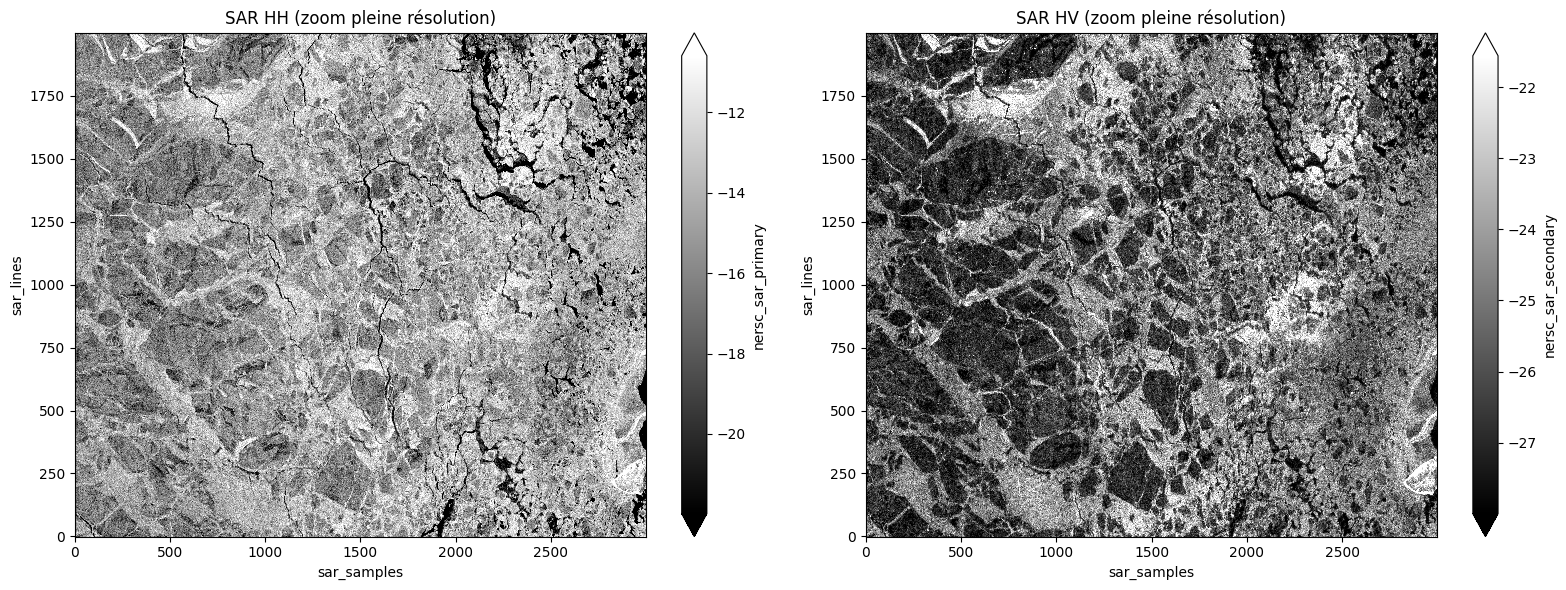

In [7]:
# Zoom sur une région
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# isel() permet de sélectionner par indices (et non par valeurs de coordonnées)
# slice(2000, 4000) sélectionne les indices de 2000 à 3999 (2000 lignes)
# Cela représente une zone de 2000x3000 pixels en pleine résolution
hh_zoom = hh.isel(sar_lines=slice(2000, 4000), sar_samples=slice(3000, 6000))
hv_zoom = hv.isel(sar_lines=slice(2000, 4000), sar_samples=slice(3000, 6000))

hh_zoom.plot(ax=axes[0], cmap="gray", robust=True)
axes[0].set_title("SAR HH (zoom pleine résolution)")

hv_zoom.plot(ax=axes[1], cmap="gray", robust=True)
axes[1].set_title("SAR HV (zoom pleine résolution)")

plt.tight_layout()
plt.show()

## 3. Données AMSR-2 (Radiomètre)

Le radiomètre AMSR-2 mesure les **températures de brillance** (en Kelvin).

Ces mesures sont liées à :
- La température physique de la surface
- L'émissivité (qui dépend du type de surface : eau, glace, neige)

### Fréquences disponibles

| Fréquence | Caractéristiques |
|-----------|------------------|
| 6.9 GHz | Pénètre profondément, sensible à la glace épaisse |
| 18.7 GHz | Bon compromis résolution/pénétration |
| 36.5 GHz | Sensible à la concentration de glace |
| 89 GHz | Haute résolution, sensible à la surface |

Chaque fréquence est disponible en polarisation **H** (horizontale) et **V** (verticale).

In [8]:
# Liste des bandes AMSR-2
# On filtre les variables qui commencent par "btemp_" (brightness temperature)
amsr2_bands = [var for var in ds.data_vars if var.startswith("btemp_")]

print("Bandes AMSR-2 disponibles :")
for band in amsr2_bands:
    print(f"  - {band}")

Bandes AMSR-2 disponibles :
  - btemp_6.9h
  - btemp_6.9v
  - btemp_7.3h
  - btemp_7.3v
  - btemp_10.7h
  - btemp_10.7v
  - btemp_18.7h
  - btemp_18.7v
  - btemp_23.8h
  - btemp_23.8v
  - btemp_36.5h
  - btemp_36.5v
  - btemp_89.0ah
  - btemp_89.0bh
  - btemp_89.0av
  - btemp_89.0bv
  - btemp_89.0h
  - btemp_89.0v


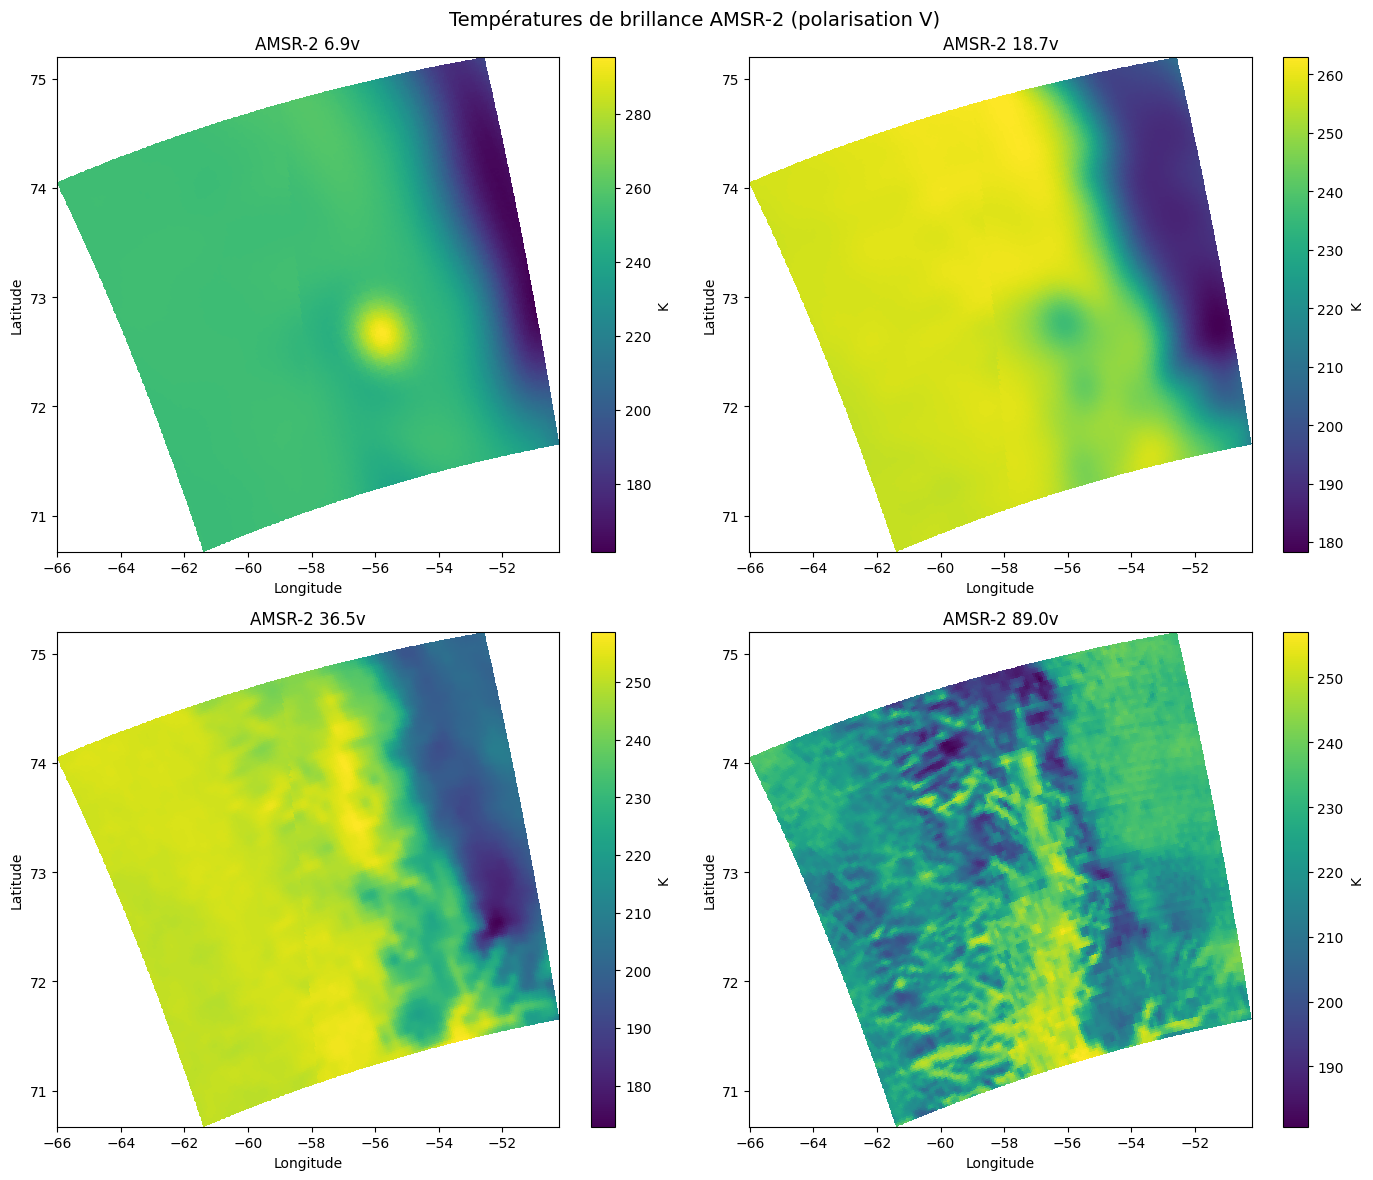

In [9]:
# Visualisation des températures de brillance
# On sélectionne 4 fréquences représentatives en polarisation V
selected_bands = ["btemp_6.9v", "btemp_18.7v", "btemp_36.5v", "btemp_89.0v"]

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()  # Convertit la matrice 2x2 en liste pour itérer facilement

# Coordonnées géographiques pour l'affichage
lat = ds["lat"]  # Latitude (degrés Nord)
lon = ds["lon"]  # Longitude (degrés Est, négatif = Ouest)

for idx, band in enumerate(selected_bands):
    tb = ds[band]  # Température de brillance
    
    # pcolormesh() crée une carte colorée sur une grille lat/lon
    # shading="auto" : gère automatiquement les bords des pixels
    # cmap="viridis" : palette de couleurs (jaune=chaud, bleu=froid)
    im = axes[idx].pcolormesh(lon, lat, tb, shading="auto", cmap="viridis")
    
    # Ajout d'une barre de couleur avec l'unité (Kelvin)
    plt.colorbar(im, ax=axes[idx], label="K")
    
    # Titre avec le nom de la bande (sans le préfixe "btemp_")
    axes[idx].set_title(f"AMSR-2 {band.replace('btemp_', '')}")
    axes[idx].set_xlabel("Longitude")
    axes[idx].set_ylabel("Latitude")

plt.suptitle("Températures de brillance AMSR-2 (polarisation V)", fontsize=14)
plt.tight_layout()
plt.show()

### Comparaison des polarisations H et V

La différence entre les polarisations H et V est liée à la structure de la surface :
- **Eau libre** : grande différence H-V
- **Glace compacte** : faible différence H-V

In [10]:
# Comparaison polarisation H vs V
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, pol in enumerate(["h", "v"]):
    # Construction du nom de la variable : btemp_36.5h ou btemp_36.5v
    tb = ds[f"btemp_36.5{pol}"]
    
    im = axes[idx].pcolormesh(lon, lat, tb, shading="auto", cmap="viridis")
    plt.colorbar(im, ax=axes[idx], label="K")
    axes[idx].set_title(f"AMSR-2 36.5 GHz - Polarisation {pol.upper()}")
    axes[idx].set_xlabel("Longitude")
    axes[idx].set_ylabel("Latitude")

plt.tight_layout()
plt.show()

## 4. Cartes de glace (Ice Charts)

Les cartes de glace sont des **annotations manuelles** réalisées par des experts.
Chaque pixel contient un code identifiant le type de glace :

- **CT** : Concentration totale de glace (0-100%)
- **CA, CB, CC** : Concentrations partielles par type
- **SA, SB, SC** : Stades de développement (âge de la glace)
- **FA, FB, FC** : Formes de glace (floes, banquise, etc.)

Ces annotations servent de **vérité terrain** pour l'entraînement de modèles de deep learning.

In [11]:
# Visualisation de la carte de glace
# Extraction de la variable polygon_icechart
icechart = ds["polygon_icechart"]

# Sous-échantillonnage pour éviter les erreurs de mémoire
icechart_subsampled = icechart[::10, ::10]

fig, ax = plt.subplots(figsize=(12, 8))

# cmap="tab20" : palette de 20 couleurs distinctes pour différencier les polygones
icechart_subsampled.plot(ax=ax, cmap="tab20", robust=True)
ax.set_title("Carte de glace (Ice Chart) - Codes des polygones")

plt.tight_layout()
plt.show()

In [12]:
# Codes des polygones
# Chaque ligne correspond à un polygone avec ses caractéristiques
# Format : id;CT;CA;SA;FA;CB;SB;FB;CC;SC;FC;CN;CD;CF;POLY_TYPE
print("Codes des polygones de glace :")
print("Format : id;CT;CA;SA;FA;CB;SB;FB;CC;SC;FC;CN;CD;CF;POLY_TYPE")
print()
for code in ds["polygon_codes"].values:
    print(code)

Codes des polygones de glace :
Format : id;CT;CA;SA;FA;CB;SB;FB;CC;SC;FC;CN;CD;CF;POLY_TYPE

id;CT;CA;SA;FA;CB;SB;FB;CC;SC;FC;CN;CD;CF;POLY_TYPE
12;92;20;98;8;20;87;-9;60;83;-9;-9;-9;-9;I
13;91;10;87;5;60;83;4;30;82;3;98;-9;-9;I
14;90;10;87;4;50;83;3;30;82;2;98;-9;-9;I
15;92;40;87;8;60;83;-9;-9;-9;-9;-9;-9;-9;I
16;92;40;87;8;60;83;-9;-9;-9;-9;-9;-9;-9;I
17;92;40;87;8;60;83;-9;-9;-9;-9;-9;-9;-9;I
18;92;20;87;8;80;83;-9;-9;-9;-9;-9;-9;-9;I
19;20;10;83;3;10;82;2;-9;-9;-9;98;-9;-9;I
20;90;40;87;6;50;83;5;10;82;3;98;-9;-9;I
21;20;10;83;3;10;82;2;-9;-9;-9;98;-9;-9;I
22;92;40;87;6;60;83;5;-9;-9;-9;98;-9;-9;I
23;92;40;87;6;60;83;5;-9;-9;-9;98;-9;-9;I
24;90;40;87;6;50;83;5;10;82;3;98;-9;-9;I
25;91;30;87;6;50;83;5;20;82;4;98;-9;-9;I
26;20;10;83;3;10;82;2;-9;-9;-9;98;-9;-9;I
27;70;30;87;6;40;83;5;10;82;3;98;-9;-9;I
28;91;20;98;10;50;87;6;30;83;6;-9;-9;-9;I
29;80;10;87;6;50;83;5;20;82;4;98;-9;-9;I
30;91;60;87;6;40;83;5;-9;-9;-9;-9;-9;-9;I
31;91;40;87;6;50;83;5;10;82;3;98;-9;-9;I
32;92;50;87;8;50;8

## 5. Données auxiliaires

### Angle d'incidence
L'angle d'incidence du radar varie de ~20° (bord proche) à ~45° (bord lointain).
Cet angle affecte la rétrodiffusion et doit être pris en compte dans l'analyse.

### Distance map
Carte des distances à certains points de référence (côtes, bords de l'image, etc.).

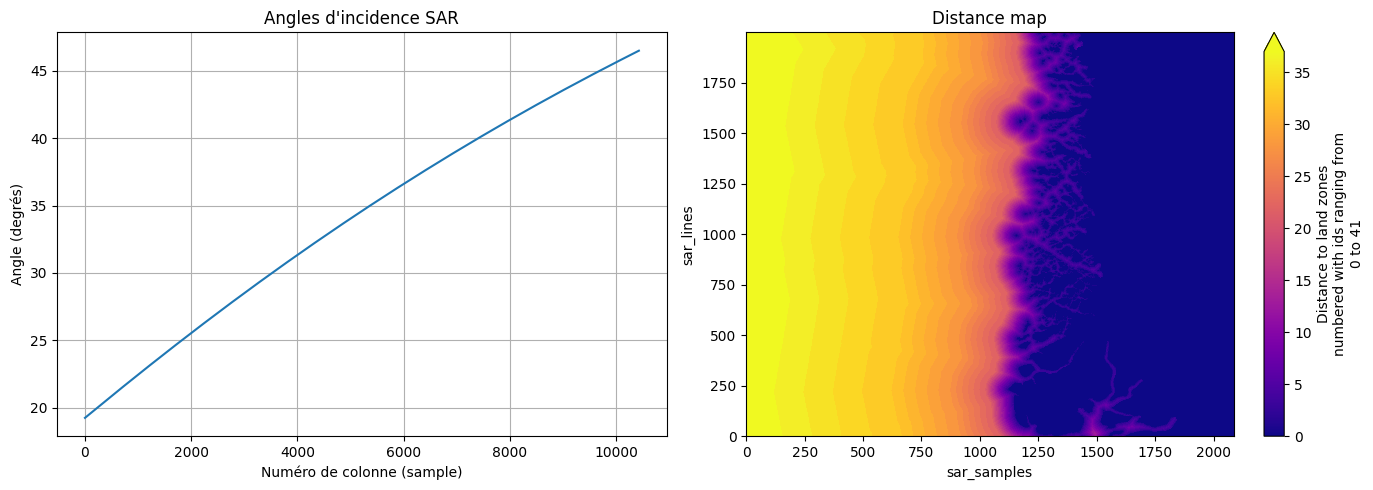

In [13]:
# Angle d'incidence et distance map
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Angle d'incidence
# C'est un vecteur 1D (une valeur par colonne de l'image)
inc_angle = ds["sar_incidenceangles"]

# Graphique linéaire montrant la variation de l'angle
axes[0].plot(inc_angle.values)
axes[0].set_title("Angles d'incidence SAR")
axes[0].set_xlabel("Numéro de colonne (sample)")
axes[0].set_ylabel("Angle (degrés)")
axes[0].grid(True)  # Ajoute une grille pour faciliter la lecture

# Distance map
dist_map = ds["distance_map"]
dist_map_subsampled = dist_map[::5, ::5]  # Sous-échantillonnage x5

# cmap="plasma" : palette allant du violet (proche) au jaune (loin)
dist_map_subsampled.plot(ax=axes[1], cmap="plasma", robust=True)
axes[1].set_title("Distance map")

plt.tight_layout()
plt.show()

## 6. Comparaison temporelle

Visualisation des 6 acquisitions pour observer l'évolution de la banquise
entre janvier et mai 2019.

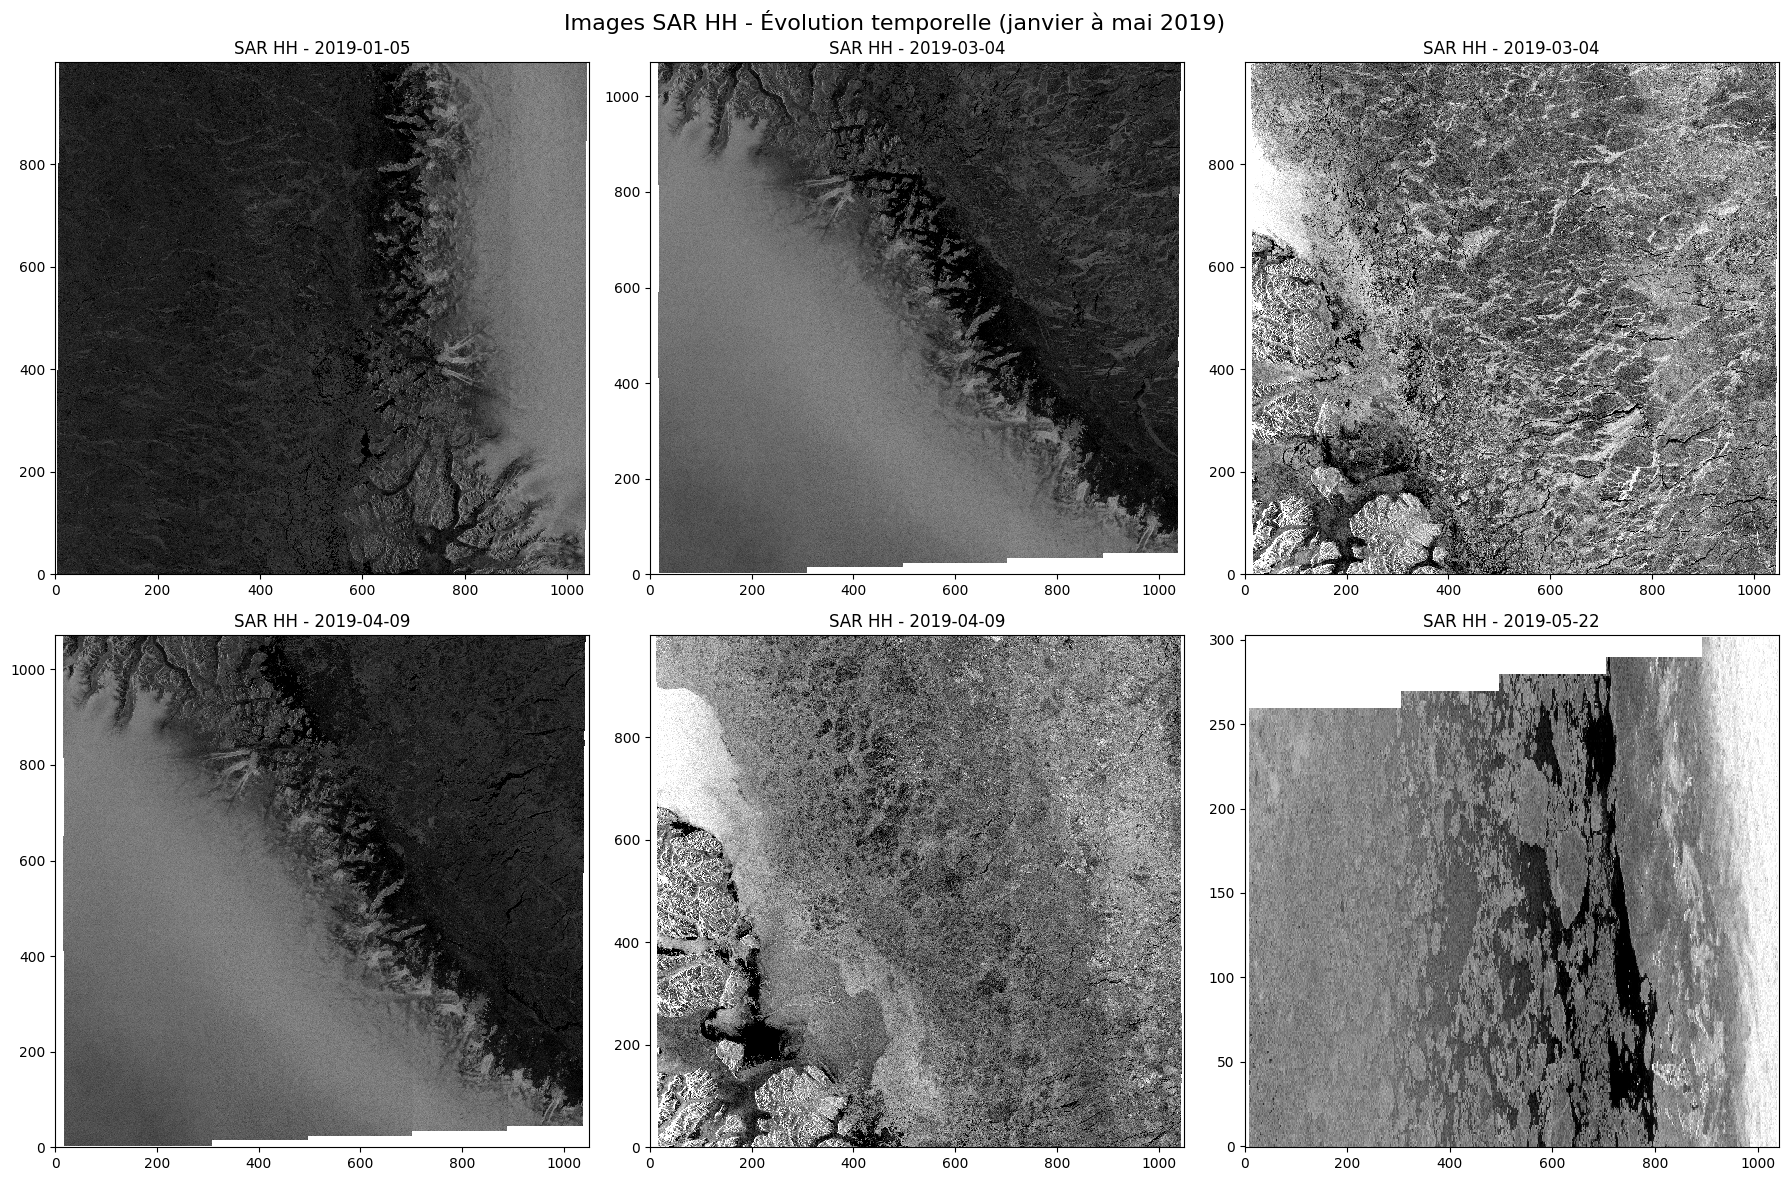

In [14]:
# Comparaison SAR HH pour toutes les dates
n_files = len(nc_files)  # Nombre de fichiers (6)
n_cols = 3               # 3 colonnes
n_rows = (n_files + n_cols - 1) // n_cols  # Calcul du nombre de lignes nécessaires

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6 * n_rows))
axes = axes.flatten()  # Convertit en liste 1D pour itérer

for idx, nc_file in enumerate(nc_files):
    # Chargement du fichier
    ds_temp = xr.open_dataset(nc_file, engine="h5netcdf")
    hh_temp = ds_temp["nersc_sar_primary"]
    
    # Sous-échantillonnage pour éviter MemoryError
    hh_subsampled = hh_temp[::10, ::10]
    
    # Extraction de la date depuis le nom de fichier (format: YYYYMMDD)
    date_str = nc_file.name[:8]
    date_formatted = f"{date_str[:4]}-{date_str[4:6]}-{date_str[6:8]}"
    
    # Affichage
    hh_subsampled.plot(ax=axes[idx], cmap="gray", robust=True, add_colorbar=False)
    axes[idx].set_title(f"SAR HH - {date_formatted}")
    axes[idx].set_xlabel("")  # Masque les labels pour plus de clarté
    axes[idx].set_ylabel("")
    
    # Fermeture du fichier pour libérer la mémoire
    ds_temp.close()

# Masquer les axes vides (si le nombre de fichiers n'est pas un multiple de n_cols)
for idx in range(n_files, len(axes)):
    axes[idx].axis('off')

plt.suptitle("Images SAR HH - Évolution temporelle (janvier à mai 2019)", fontsize=16)
plt.tight_layout()
plt.show()

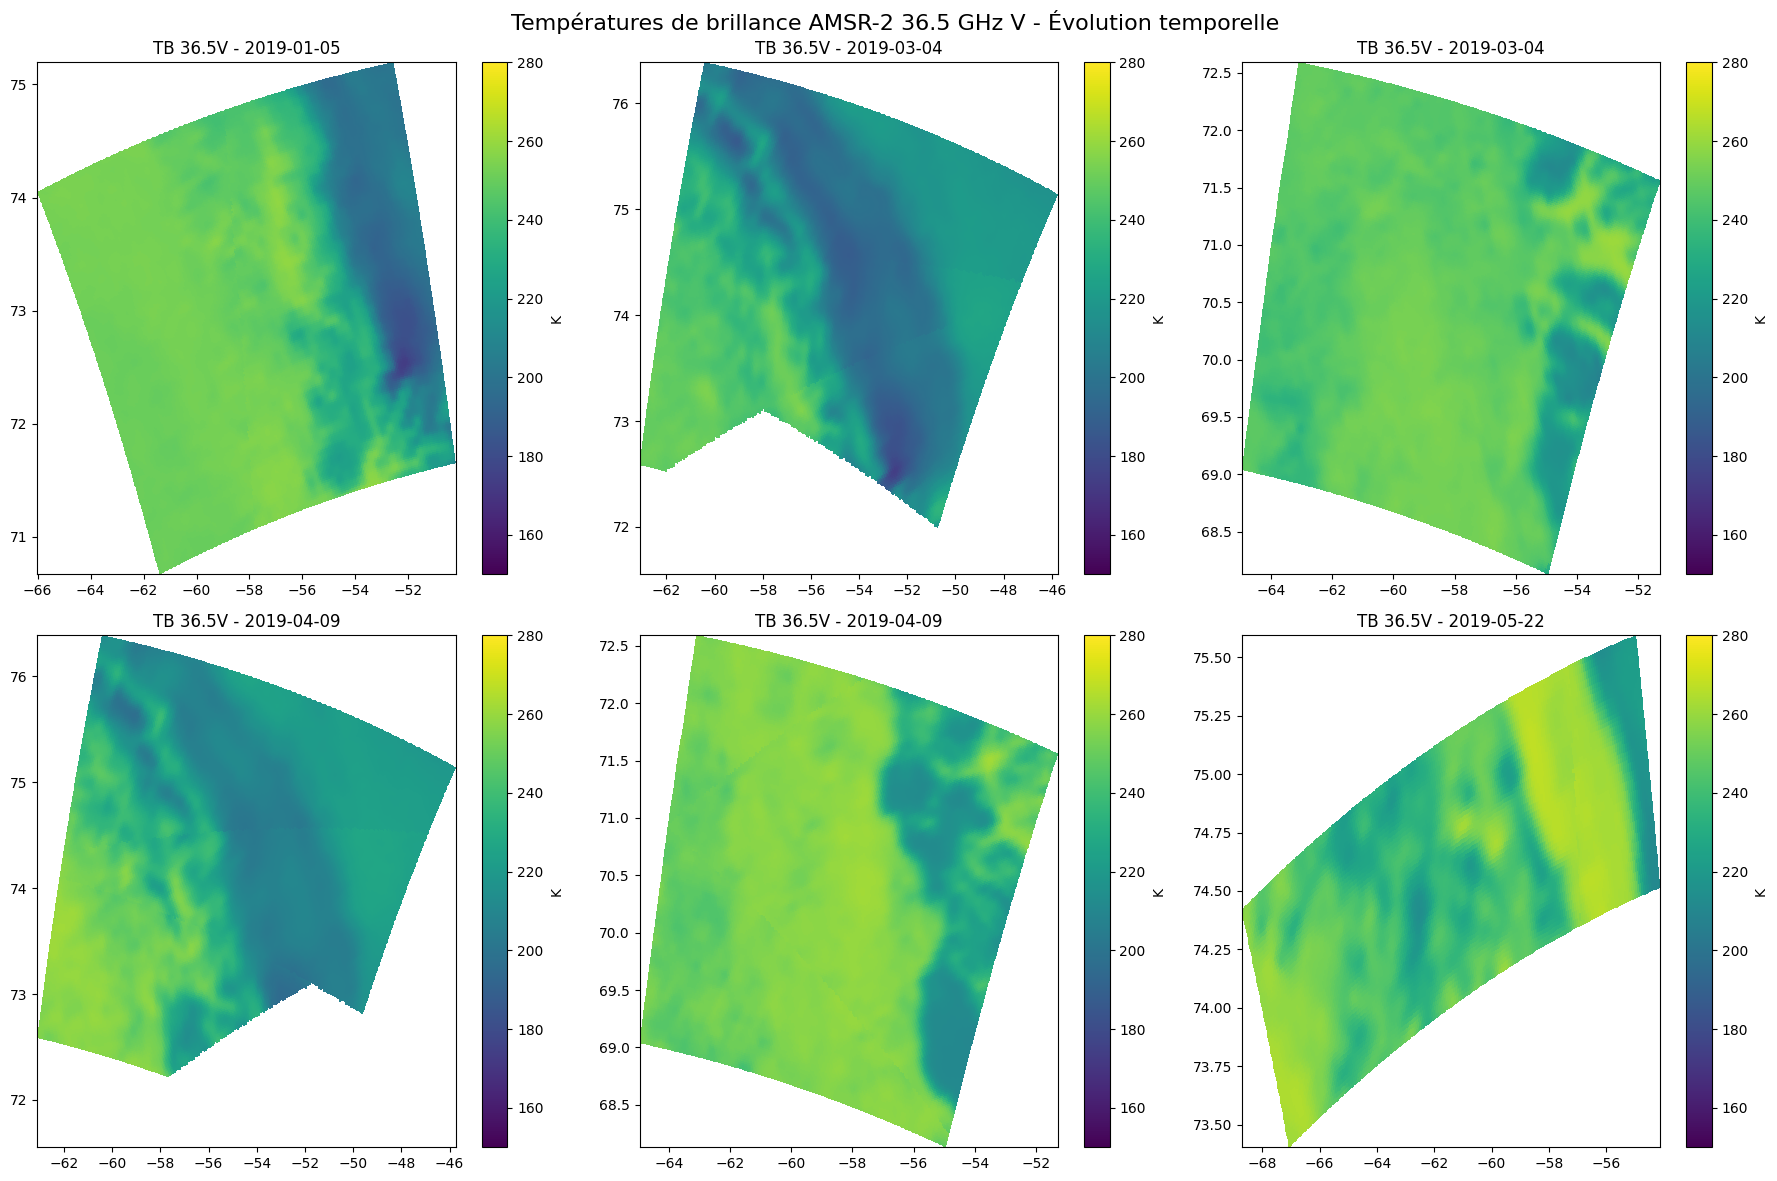

In [15]:
# Comparaison AMSR-2 36.5 GHz V pour toutes les dates
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6 * n_rows))
axes = axes.flatten()

for idx, nc_file in enumerate(nc_files):
    ds_temp = xr.open_dataset(nc_file, engine="h5netcdf")
    
    # Extraction des données
    tb = ds_temp["btemp_36.5v"]
    lat_temp = ds_temp["lat"]
    lon_temp = ds_temp["lon"]
    
    date_str = nc_file.name[:8]
    date_formatted = f"{date_str[:4]}-{date_str[4:6]}-{date_str[6:8]}"
    
    # vmin=150, vmax=280 : fixe l'échelle de couleurs pour comparer les images
    im = axes[idx].pcolormesh(lon_temp, lat_temp, tb, shading="auto", 
                               cmap="viridis", vmin=150, vmax=280)
    axes[idx].set_title(f"TB 36.5V - {date_formatted}")
    plt.colorbar(im, ax=axes[idx], label="K")
    
    ds_temp.close()

for idx in range(n_files, len(axes)):
    axes[idx].axis('off')

plt.suptitle("Températures de brillance AMSR-2 36.5 GHz V - Évolution temporelle", fontsize=16)
plt.tight_layout()
plt.show()

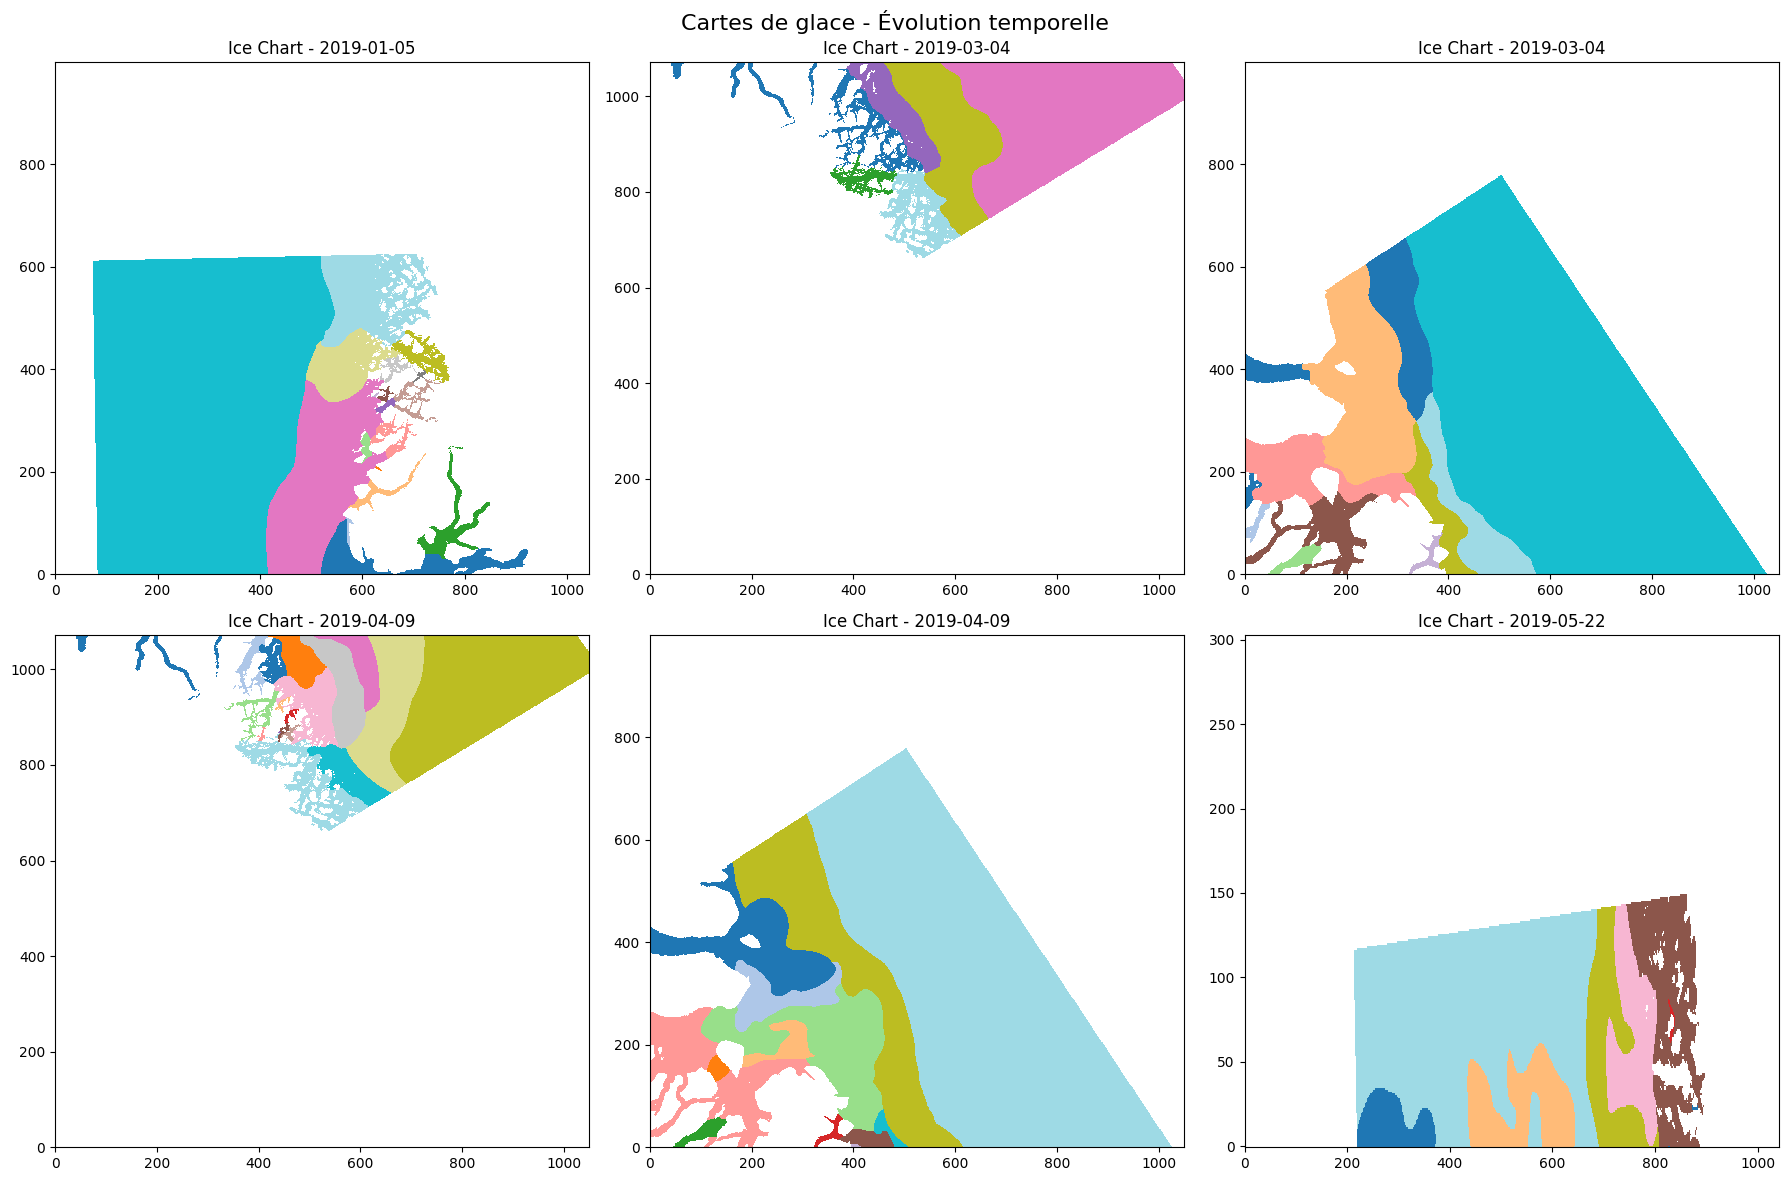

In [16]:
# Comparaison des cartes de glace pour toutes les dates
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6 * n_rows))
axes = axes.flatten()

for idx, nc_file in enumerate(nc_files):
    ds_temp = xr.open_dataset(nc_file, engine="h5netcdf")
    
    # Carte de glace sous-échantillonnée
    icechart_temp = ds_temp["polygon_icechart"]
    icechart_subsampled = icechart_temp[::10, ::10]
    
    date_str = nc_file.name[:8]
    date_formatted = f"{date_str[:4]}-{date_str[4:6]}-{date_str[6:8]}"
    
    icechart_subsampled.plot(ax=axes[idx], cmap="tab20", robust=True, add_colorbar=False)
    axes[idx].set_title(f"Ice Chart - {date_formatted}")
    axes[idx].set_xlabel("")
    axes[idx].set_ylabel("")
    
    ds_temp.close()

for idx in range(n_files, len(axes)):
    axes[idx].axis('off')

plt.suptitle("Cartes de glace - Évolution temporelle", fontsize=16)
plt.tight_layout()
plt.show()

## 7. Statistiques des données

Calcul des statistiques descriptives pour chaque acquisition SAR.

In [17]:
# Statistiques SAR HH pour chaque fichier
print("Statistiques des données SAR HH pour chaque fichier :")
print()

for nc_file in nc_files:
    ds_temp = xr.open_dataset(nc_file, engine="h5netcdf")
    hh_temp = ds_temp["nersc_sar_primary"]
    
    date_str = nc_file.name[:8]
    date_formatted = f"{date_str[:4]}-{date_str[4:6]}-{date_str[6:8]}"
    
    # Calcul des statistiques
    # float() convertit le résultat xarray en nombre Python
    print(f"{date_formatted}:")
    print(f"  Shape: {hh_temp.shape}")                      # Dimensions de l'image
    print(f"  Min:   {float(hh_temp.min()):.2f} dB")        # Valeur minimale
    print(f"  Max:   {float(hh_temp.max()):.2f} dB")        # Valeur maximale
    print(f"  Mean:  {float(hh_temp.mean()):.2f} dB")       # Moyenne
    print(f"  Std:   {float(hh_temp.std()):.2f} dB")        # Écart-type
    print()
    
    ds_temp.close()

Statistiques des données SAR HH pour chaque fichier :

2019-01-05:
  Shape: (9993, 10430)
  Min:   -29.43 dB
  Max:   15.71 dB
  Mean:  -12.48 dB
  Std:   6.10 dB

2019-03-04:
  Shape: (10715, 10499)
  Min:   -28.99 dB
  Max:   15.51 dB
  Mean:  -9.03 dB
  Std:   6.70 dB

2019-03-04:
  Shape: (10000, 10498)
  Min:   -29.09 dB
  Max:   16.75 dB
  Mean:  -14.14 dB
  Std:   3.26 dB

2019-04-09:
  Shape: (10716, 10496)
  Min:   -31.37 dB
  Max:   16.51 dB
  Mean:  -9.27 dB
  Std:   6.83 dB

2019-04-09:
  Shape: (10000, 10495)
  Min:   -30.06 dB
  Max:   16.40 dB
  Mean:  -13.95 dB
  Std:   3.10 dB

2019-05-22:
  Shape: (3029, 10417)
  Min:   -30.14 dB
  Max:   9.85 dB
  Mean:  -14.92 dB
  Std:   5.68 dB



In [18]:
# Fermeture du dataset principal
# Important pour libérer la mémoire
ds.close()

print("Exploration terminée !")

Exploration terminée !
